<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.1

# Description


In my project, I wanted to answer the question: what will the Pittsburgh Steelers next offensive score be in their next football game?

Football is an American sport where each team starts on offense or defense and attempts to score points by scoring a touchdown or making a field goal while the other team attempts to get a turnover. A touchdown is 7 points, while a field goal is 3 points, and the scores vary week-by-week depending on the strength of a defense. Teams play 17 games over the course of a season, with one game a week and one 'bye' week in which they don't have to play.


The Pittsburgh Steelers is a prominent football team in the National Football League, the largest football league in the world. The team is named after Pittsburgh's prominent steel industry.

# Context
For the likelihood of the Steelers actual offensive points, I created a dataset of the Steelers offensive points from the 2023-2024 season and the games thus far in the 2024-2025 season. These values are openly stored on the Steelers website, so it was simple to compile them and transfer to find an average points per game of 18.

After choosing the likelihood, I plotted the raw data onto a histogram to demonstrate the distribution of the values and used that to decide what preliz distribution my posterior uses.

In [54]:
url_points = "https://raw.githubusercontent.com/Ankit-LASA/Data-Science/main/points.csv"
observedData = pd.read_csv(url_points)

(array([2., 3., 2., 4., 2., 2., 4., 1., 1., 1.]),
 array([ 6. ,  8.8, 11.6, 14.4, 17.2, 20. , 22.8, 25.6, 28.4, 31.2, 34. ]),
 <BarContainer object of 10 artists>)

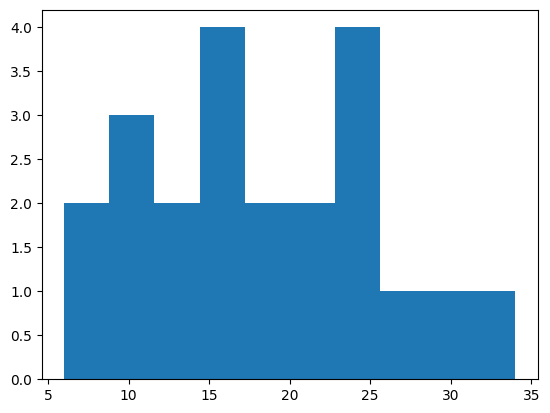

In [55]:
plt.hist(observedData)

For the posterior, I decided to use a Gamma distribution to represent the average score in the NFL. I did this for a litany of reasons. It is one of the only distributions that only contains positive values which is necessary to represent NFL scores (as a team can't have 'negative' points). Furthermore, it allows a distribution that centers around the mean and reduces probability as the deviation increases, which replicates the data in the likelihood above (since the values in the middle had a higher frequency). Lastly, it has a larger range than just 1s and 0s because it is supposed to demonstrate numerical values, which forecloses the Bernoulli and Binomial distribtuions.

After getting an idea for the likelihood, I had some trouble choosing and eventually landing on a good prior.

# Creating the Model


In [148]:
#Feel free to look through the actual modelling in the prior, but I condensed them so you can see the process in which I adjusted it.

## Attempt 1
When forming the first prior, I already knew that the Steelers were a relatively low scoring NFL team in the 2023-2024 season. I also knew that the league average for PPG (points per game) was 21.8 over that season. However, I needed to be more specific. I calculated the lower quartile median value of team NFL scores, finding that it was the Washington Commanders with 19.4 PPG. This would become the mu in the model as that is where I wished the data to 'center' around. To demonstrate this 'centerdness', I chose to use a Weibull distribution.

However, this data was very uncertain and didn't necesariy represent and accurate vision of the Steelers offense. The Steeers has recently hired a new offensive coordinator and transitioned to a new quarterback which both threaten to change the course of its offensive scoring. Additionally, season-to-season variability may skew the data upwards or downwards, further reducing the certainty in the model. To demonstrate this, I used a uniform model for the standard deviation as I really don't have a clue to what the average variance will center around. To maintain some realism of solely positive values and scores that are realistic in the NFL, I set the lower bound to 0 (the lowest observed difference between data points) and the upper bound to 28 (the highest observed difference between two data points).

<Axes: >

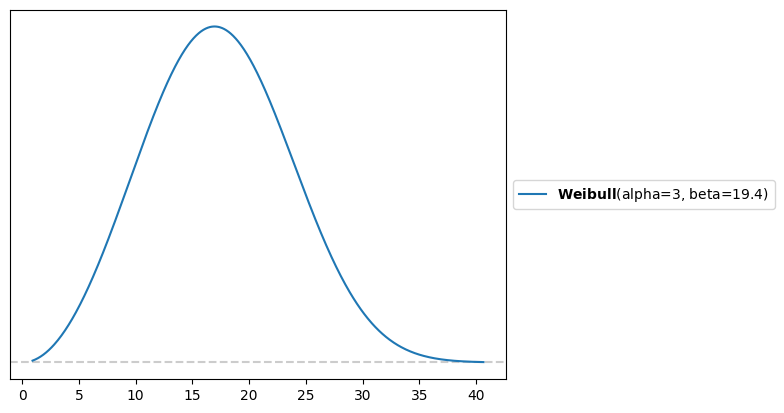

In [75]:
muDist = pz.Weibull(alpha=3, beta = 19.4)
pz.Weibull(alpha=3, beta = 19.4).plot_pdf()

<Axes: >

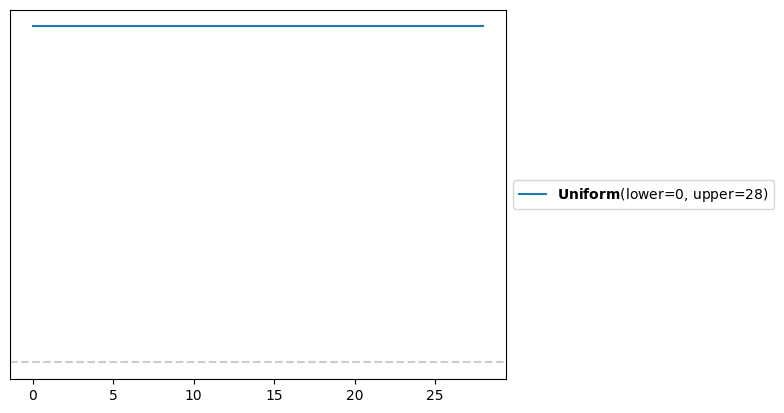

In [76]:
sigmaDist = pz.Uniform(0,28)
pz.Uniform(0,28).plot_pdf()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

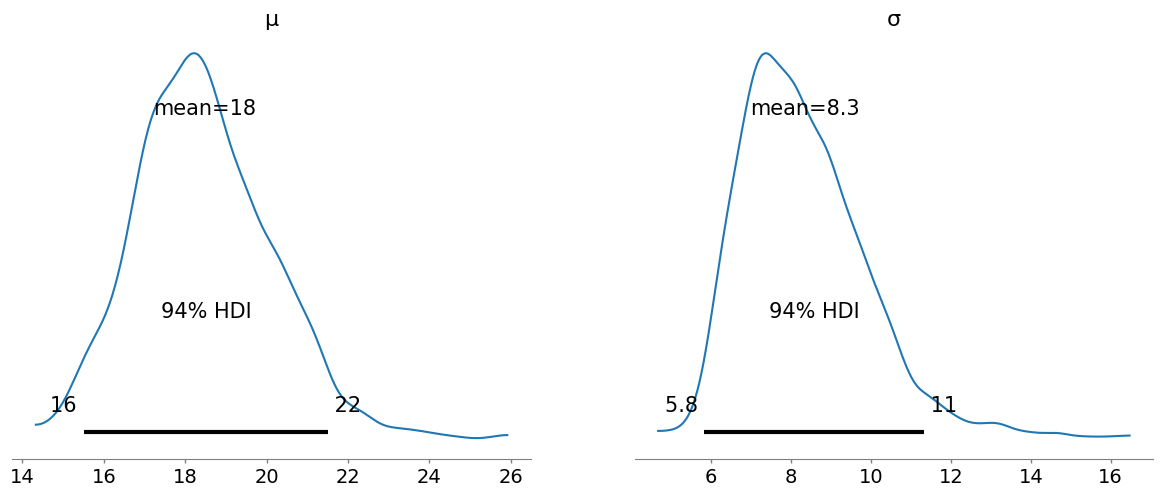

In [95]:
with pm.Model() as model_scoresG:
  μ = pm.Weibull('μ', alpha=3, beta = 19.4)
  σ = pm.Uniform('σ',lower=0, upper=28)
  Y = pm.Gamma('Y', mu = μ, sigma = σ, observed=observedData)
  idata_scoresG = pm.sample()
az.plot_posterior(idata_scoresG)

In [96]:
pm.sample_posterior_predictive(idata_scoresG, model=model_scoresG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

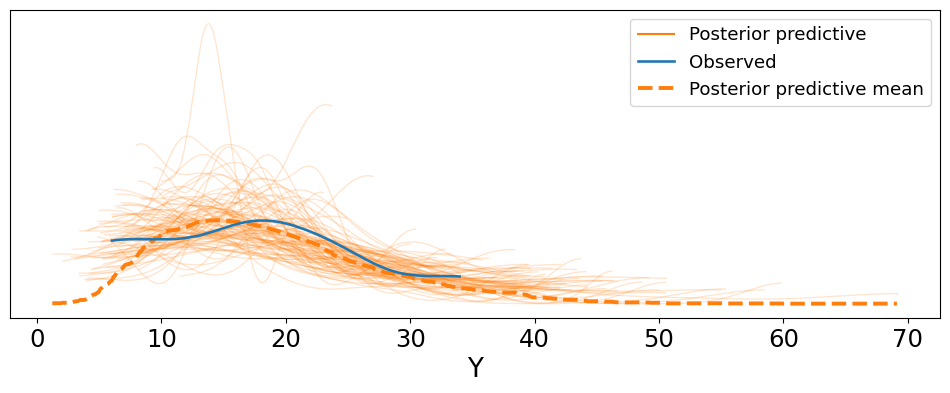

In [97]:
az.plot_ppc(idata_scoresG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## Attempt 2
On my second attempt for the model, I wanted to refine the distributions to make them more 'real world'.

I realized that the distribution for the mu value shouldn't have any skewness, as I don't have a clue which 'direction' the average points would err to. This rules out using Gamma and the Weibull distributions as both always have some skewness. Instead, I needed to use the Normal distribtuion. However, since there can't be negative values, I needed to truncate the graph.

In [91]:
#muDist = pm.TruncatedNormal('μ', mu = 19.4, sigma = 3, lower = 0)
#can't plot this on a graph because it's only available in pymc models

I then used this to recreate the posterior. I chose to use 3 as the sigma because I knew there would be a minor deviation, but one that shouldn't be extremely high or low.

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

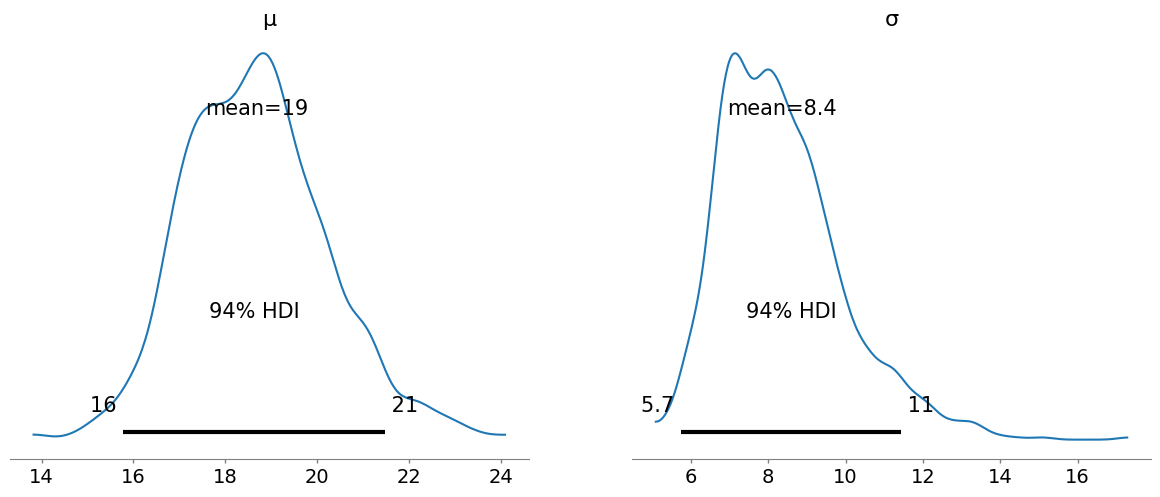

In [98]:
with pm.Model() as model_scoresG:
  μ = pm.TruncatedNormal('μ', mu = 19.4, sigma = 3, lower = 0)
  σ = pm.Uniform('σ',lower=0, upper=28)
  Y = pm.Gamma('Y', mu = μ, sigma = σ, observed=observedData)
  idata_scoresG = pm.sample()
az.plot_posterior(idata_scoresG)

In [99]:
pm.sample_posterior_predictive(idata_scoresG, model=model_scoresG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

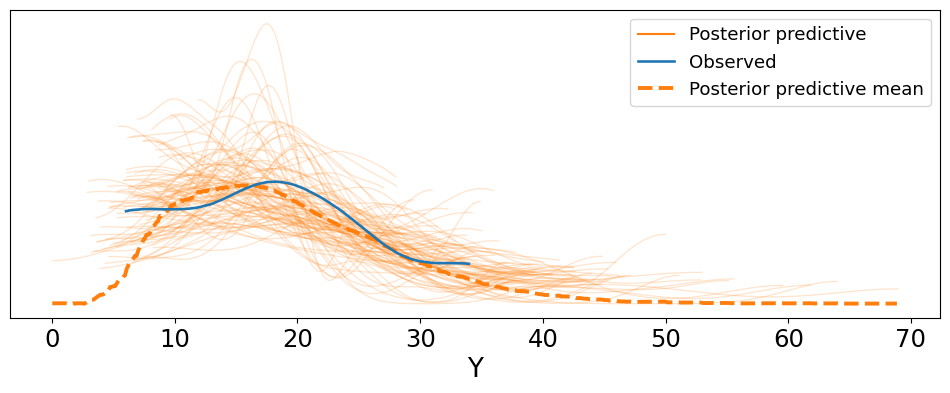

In [100]:
az.plot_ppc(idata_scoresG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

With this model, the mean of the posterior predictive better aligned the observed values, but there were a lot more values further to the right that created a small skewness.

## Attempt 3
For my third prior, I hoped to further approximate the data. Obviously, due to the fact that my data set was small, there will be a significant variance, but I thought I could be more precise than a uniform distribution in my standard deviation.

To correct this fault, I decided to create a gamma distribution centered around my ideal mean. I chose the gamma distribution because I knew that there would be **some** deviation, and that it would be extremely unlikely to have a standard deviation of 0, as, in the NFL teams usually deviate scores from game to game. Therefore, I ruled out all half distributions and the uniform distribution (since I want the probability of a 0 value for the sigma to be near 0). As it is a standard deviation, it still needs to hold **only** positive values.

To find the deviation, I calculated the standard deviation of data set I'm using for the mu values. Because the Commanders were the third quartile team from my dataset, I calculated their standard deviation by plugging in their scores in the 2023-2024 season. After calculating, I discovered the standard deviation should be about 9.22. I arbritarily chose my sigma because I knew that this could differ marginaly from team to team, but not to a large extent.

<Axes: >

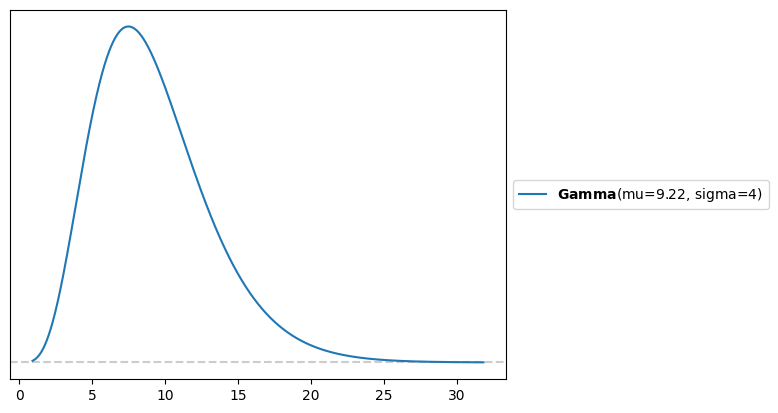

In [144]:
sigmaDist = pz.Gamma(sigma=4, mu = 9.22)
pz.Gamma(sigma=4, mu = 9.22).plot_pdf()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

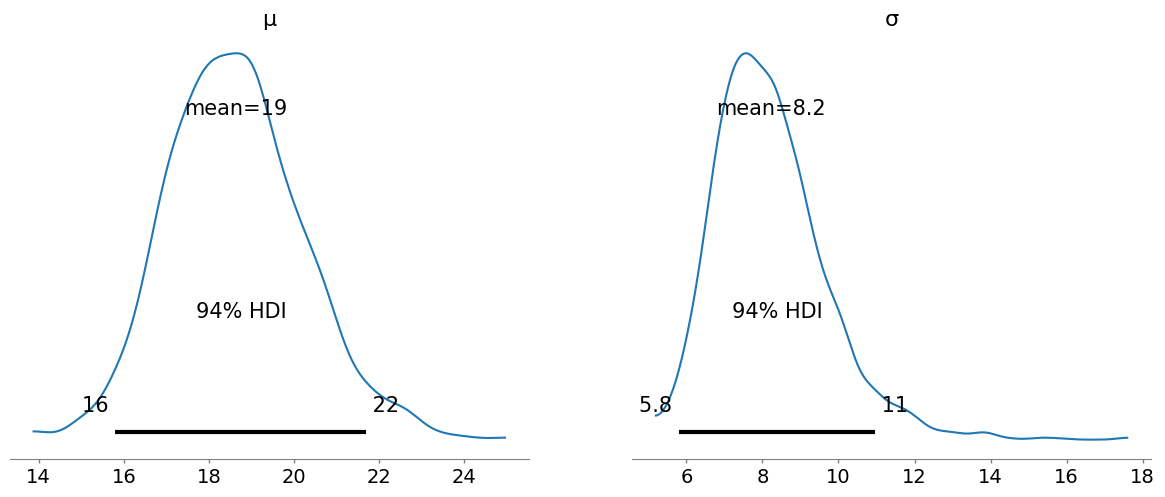

In [145]:
with pm.Model() as model_scoresG:
  μ = pm.TruncatedNormal('μ', mu = 19.4, sigma = 3, lower = 0)
  σ = pm.Gamma('σ', sigma = 4, mu = 9.22)
  Y = pm.Gamma('Y', mu = μ, sigma = σ, observed=observedData)
  idata_scoresG = pm.sample()
az.plot_posterior(idata_scoresG)

In [146]:
pm.sample_posterior_predictive(idata_scoresG, model=model_scoresG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

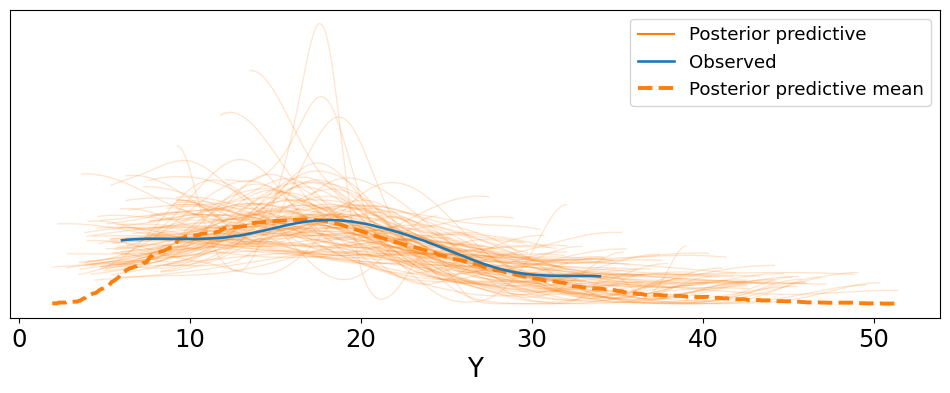

In [147]:
az.plot_ppc(idata_scoresG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Conclusion

According to the model, the scores for the next game is likely to hover around 15-20 points.

The model matched the observed data somewhat, but it stil contained far too much variance with a substantially weak prior. I believe this was probably due to a small data set with a limited amount of values (compared to other projects I've seen). This occurred due a problematic tradeoff: due to the infrequency of NFL games, as you use more 'data' for offensive scores, that data is less applicable to the current offense since players, coaches, and schemes switch up. In short, it's hard to find an NFL teams next offensive score with outdated knowledge. However, it is somewhat useful to get a general idea of likely scores. The large uncertainty explains why the model has such a large amount of lines straying away from the mean posterior predictive and the observed data.

These inconsistencies can be fixed in the future by taking in more observed data (which would be difficult but feasible if you account for extraneous scores) and adjusting the prior to be more accurate to the Steelers actual score. For example, in my prior I had to choose the lowest quartile, but it could be more accurate if I was able to discover the lowest